In [1]:
import os

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [2]:
# Register your dataset
register_coco_instances(
    "fish_train", {},
    "../data/training/coco/annotations_train.json",
    "../data/training/coco/images/",
)

register_coco_instances(
    "fish_val", {},
    "../data/training/coco/annotations_val.json",
    "../data/training/coco/images/",
)

In [3]:
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

class FishTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [4]:
# Config setup
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"
))


cfg.DATASETS.TRAIN = ("fish_train",)
cfg.DATASETS.TEST = ("fish_val", )
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"
)


cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

cfg.SOLVER.MAX_ITER = 30000             # extend for full overnight training
cfg.SOLVER.STEPS = (7000, 9000)         # decay learning rate during training
cfg.SOLVER.GAMMA = 0.1                  # stronger LR decay factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 100           # short warmup, since pretrained weights

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only fish

cfg.INPUT.MIN_SIZE_TRAIN = (128,)
cfg.INPUT.MAX_SIZE_TRAIN = 256
cfg.INPUT.MIN_SIZE_TEST = 128
cfg.INPUT.MAX_SIZE_TEST = 256
cfg.INPUT.FORMAT = "BGR"

cfg.INPUT.RANDOM_FLIP = "horizontal"  # you can keep this
cfg.INPUT.CROP.ENABLED = False

cfg.OUTPUT_DIR = "../data/models/mask_rcnn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [5]:
# Train
trainer = FishTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/31 00:24:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/31 00:24:41 d2.engine.train_loop]: Starting training from iteration 0


d:\Projects\FishMaze\venv\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/31 00:24:47 d2.utils.events]:  eta: 1:18:43  iter: 19  total_loss: 1.492  loss_cls: 0.7097  loss_box_reg: 0.0539  loss_mask: 0.6938  loss_rpn_cls: 0.02845  loss_rpn_loc: 0.003092    time: 0.1585  last_time: 0.1516  data_time: 0.1143  last_data_time: 0.0016   lr: 4.7702e-05  max_mem: 2235M
[03/31 00:24:50 d2.utils.events]:  eta: 1:18:49  iter: 39  total_loss: 0.9255  loss_cls: 0.153  loss_box_reg: 0.06321  loss_mask: 0.675  loss_rpn_cls: 0.02438  loss_rpn_loc: 0.002708    time: 0.1582  last_time: 0.1557  data_time: 0.0013  last_data_time: 0.0012   lr: 9.7652e-05  max_mem: 2235M
[03/31 00:24:53 d2.utils.events]:  eta: 1:18:56  iter: 59  total_loss: 0.8226  loss_cls: 0.1005  loss_box_reg: 0.05859  loss_mask: 0.6366  loss_rpn_cls: 0.02317  loss_rpn_loc: 0.002572    time: 0.1583  last_time: 0.1586  data_time: 0.0013  last_data_time: 0.0014   lr: 0.0001476  max_mem: 2235M
[03/31 00:24:56 d2.utils.events]:  eta: 1:18:59  iter: 79  total_loss: 0.7616  loss_cls: 0.09814  loss_box_reg: 0.073

[03/31 02:10:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../data/models/mask_rcnn/model_final.pth ...


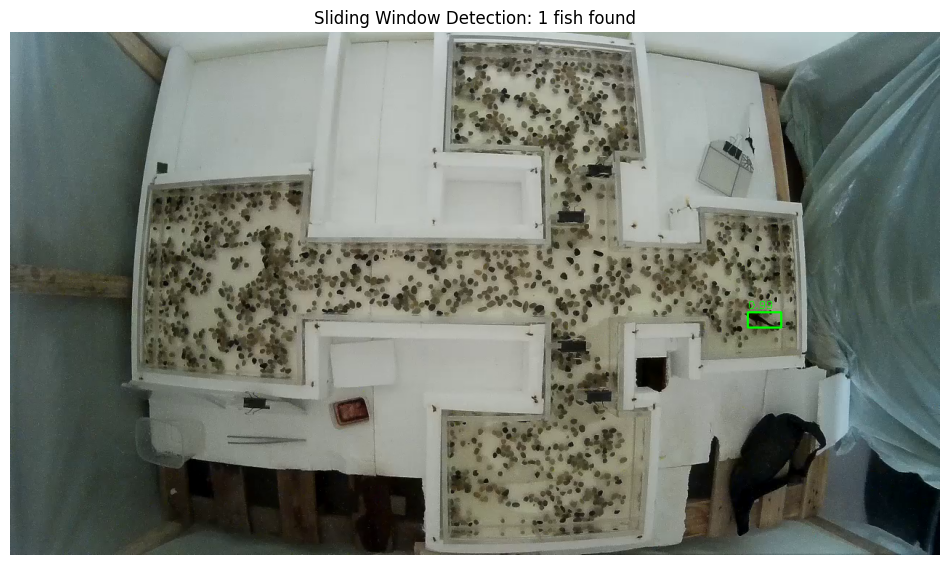

In [6]:
import cv2
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_PATH = "../data/training/testing/mask_rcnn/frame_37920.png"
MODEL_WEIGHTS = "../data/models/mask_rcnn/model_final.pth"  # path to trained model
WINDOW_SIZE = 256
STRIDE =  128 # overlapping windows
SCORE_THRESH = 0.9

# --- SETUP DETECTRON2 CONFIG ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"
))
cfg.MODEL.WEIGHTS = MODEL_WEIGHTS
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = SCORE_THRESH
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MIN_SIZE_TEST = WINDOW_SIZE
cfg.INPUT.MAX_SIZE_TEST = WINDOW_SIZE

predictor = DefaultPredictor(cfg)

# --- SLIDING WINDOW INFERENCE ---
image = cv2.imread(IMAGE_PATH)
H, W = image.shape[:2]
detections = []

for y in range(0, H - WINDOW_SIZE + 1, STRIDE):
    for x in range(0, W - WINDOW_SIZE + 1, STRIDE):
        tile = image[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
        outputs = predictor(tile)
        instances = outputs["instances"].to("cpu")

        for i in range(len(instances)):
            score = instances.scores[i].item()
            if score >= SCORE_THRESH:
                mask = instances.pred_masks[i].numpy()
                bbox = instances.pred_boxes[i].tensor.numpy()[0]  # [x1, y1, x2, y2]

                x1, y1, x2, y2 = bbox
                global_bbox = [x + x1, y + y1, x + x2, y + y2]

                # Get the centroid from the mask using moments
                M = cv2.moments(mask.astype(np.uint8))
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"]) + x
                    cy = int(M["m01"] / M["m00"]) + y
                    centroid = (cx, cy)
                else:
                    centroid = (0, 0)

                # Get the global centroid coordinates
                global_centroid = (centroid[0] + x, centroid[1] + y)


                detections.append((global_bbox, score, global_centroid))

# Sort by score
detections.sort(key=lambda x: x[1], reverse=True)

# --- DRAW RESULTS ON ORIGINAL IMAGE ---
vis_img = image.copy()
for bbox, score, center in detections[:1]:
    x1, y1, x2, y2 = map(int, bbox)
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.circle(vis_img, center, 3, (255, 0, 0), -1)
    cv2.putText(vis_img, f"{score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# --- DISPLAY ---
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Sliding Window Detection: {len(detections)} fish found")
plt.show()